<a href="https://colab.research.google.com/github/ramtiin/Word-cloud-for-most-recent-tweets-and-their-polarity-with-sentiment-analysis/blob/main/What's_Happening!%3F_Stay_up_to_date_at_a_glance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

It would be cool to know about hot topics and their impact at a glance, right?
This idea hit me some time ago, so I decided to put it into practice. To get the job done, I used [TWINT](https://github.com/twintproject/twint) (Twitter Intelligence Tool) to download tweets from the most popular news agencies and extract keywords from them. In the next steps, I plotted a [word cloud](https://en.wikipedia.org/wiki/Tag_cloud) and did a sentiment analysis for tweets that have the keywords.

In [1]:
%%capture
!git clone --depth=1 https://github.com/ramtiin/twint.git #The original TWINT repository has some problems with downloading tweets, so I forked it and fixed it.
%cd twint
!pip install . -r requirements.txt
!pip install vaderSentiment
!pip install wordcloud
!pip install yake
!pip install nest_asyncio

#In order to twint works correctly in notebook:
import nest_asyncio
nest_asyncio.apply()

You can add your desired twitter accounts ID here:

In [2]:
accounts = ['BBCWorld','CBSNews','washingtonpost','CNN','YahooNews','guardian','TheEconomist','business'] 

To get tweets older than a day, edit this part:

In [3]:
from datetime import date
from datetime import timedelta
DT = (date.today() - timedelta(days=1)).strftime("%Y-%m-%d")

Progress bar for indicating how much is left to download all the tweets:

In [4]:
import progressbar
bar = progressbar.ProgressBar(maxval=len(accounts), \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

In order to download tweets using Twint:

In [5]:
bar.start() #the start of the progress bar

for idx,account in enumerate(accounts):
  !twint -fr -u $account --since $DT -o $account'.csv' --csv &> /dev/null #the twint command
  bar.update(idx+1)

bar.finish() #the end of the progress bar


[========================================================================] 100%


We will use Yet Another Keyword Extractor (Yake) for extracting keywords for each tweet.


*Parameters:*

*   The max_ngram_size is limit the word count of the extracted keyword. If you keep max_ngram_size=2, then keyword length will not increase more than 2. But, It will also have keywords with a size less than 2.
*   With the duplication_threshold variable, you can limit the repetition of words across keywords. If you want to avoid the repetition of words in keywords, you can set the deduplication_threshold value to 0.1. If you set the threshold value to 0.9, repetition of words is allowed in keywords.
* The numOfKeywords is the number of keyphrases to extract.

You can leave parameters as it is.



In [6]:
import yake
kw_extractor = yake.KeywordExtractor()
language = "en"
max_ngram_size = 2
deduplication_threshold = 0.3
numOfKeywords = 4
custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=numOfKeywords, features=None)

In this part, I wrote a function to prevent duplicate or incomplete keywords that might appear after the keyword extraction process by replacing them with more understandable words for the Yake library. You can edit the list by your choice, and the writing styles of the Twitter accounts.

In [7]:
import re

def replace_strings(text):
  rep = {"President Joe Biden": "Joe Biden", "President Biden": "Joe Biden","New York City":"NYC"} # define desired replacements here
  rep = dict((re.escape(k), v) for k, v in rep.items()) 
  pattern = re.compile("|".join(rep.keys()))
  return pattern.sub(lambda m: rep[re.escape(m.group(0))], text)


In [9]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()



merged_df = pd.DataFrame()
tweets = pd.Series(dtype='str')
noun_phrases = pd.Series(dtype='object')

for account in accounts:
  dataframe = pd.read_csv(str(account)+".csv",sep="\t") [['date', 'time','username', 'tweet']]
  dataframe['date_time'] = pd.to_datetime(dataframe['date'] + ' ' + dataframe['time'])
  dataframe.set_index('date_time',inplace=True)
  dataframe.drop(['date','time'],axis=1,inplace=True)
  dataframe['tweet'] = dataframe['tweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0].strip())    #Removing URLs from tweets
  dataframe['tweet'] = dataframe['tweet'].apply(lambda x: re.split('#[A-Za-z0-9_]+', str(x))[0].strip())  #Removing hashtags from tweets
  dataframe['tweet'] = dataframe['tweet'].str.replace("\"",'')
  dataframe['tweet'] = dataframe['tweet'].apply(lambda x: replace_strings(x))
  dataframe.drop_duplicates(subset='tweet', keep="first",inplace=True)
  dataframe['noun phrases'] = dataframe['tweet'].apply(lambda x: [*dict(custom_kw_extractor.extract_keywords(x))])
  dataframe['sentiment'] = [analyzer.polarity_scores(x)['compound'] for x in dataframe['tweet']]
  dataframe.rename(columns={'sentiment':'sentiment_'+str(account)}, inplace=True)

  tweets = pd.concat([tweets,dataframe['tweet']])
  noun_phrases =pd.concat([noun_phrases,dataframe['noun phrases']])


  dataframe.drop(['username','tweet'],axis=1,inplace=True)
  dataframe = pd.DataFrame(dataframe['sentiment_'+str(account)].resample('1D').mean()[DT:]) #Here we index tweets by day to merge them easily with tweets downloaded by other Twitter accounts.
                                                                                            #Also, older tweets than the date we choose are sometimes downloaded, so we filter them here.
  print(str(account))
  if merged_df.empty:
    merged_df = dataframe.copy()
  else:
    merged_df = merged_df.merge(dataframe,on=['date_time'])

BBCWorld
CBSNews
washingtonpost
CNN
YahooNews
guardian
TheEconomist
business


Now, let's count the repetition of each phrase:

In [10]:
from collections import Counter
word_could_dict=Counter([x.lower() for x in noun_phrases.sum()])

Some words may not contain enough information. We can remove them here:

In [11]:
entries_to_remove = ['sen']
for k in entries_to_remove:
    word_could_dict.pop(k, None)

And finally, the most exciting part; drawing the word cloud:

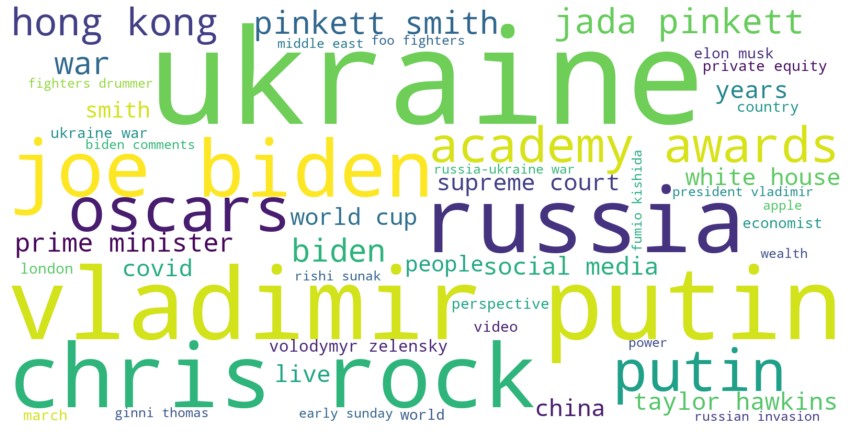

In [12]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

wordcloud = WordCloud( width=1600, max_words=50,height=800,collocations=False, background_color='white').generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

If you don't like word clouds, this is for you :)

The code shows how many times a phrase is exactly repeated:

In [16]:
sorted(word_could_dict.items(), key=lambda x: x[1], reverse=True)[:20]

[('ukraine', 44),
 ('vladimir putin', 32),
 ('russia', 26),
 ('chris rock', 25),
 ('joe biden', 24),
 ('oscars', 14),
 ('putin', 12),
 ('academy awards', 10),
 ('hong kong', 10),
 ('jada pinkett', 8),
 ('pinkett smith', 8),
 ('war', 8),
 ('biden', 8),
 ('prime minister', 8),
 ('social media', 7),
 ('taylor hawkins', 7),
 ('years', 7),
 ('supreme court', 7),
 ('white house', 7),
 ('covid', 7)]

How about doing sentiment analysis on the most important topics (most repeated phrases) and finding out the polarity of tweets that are about them?

In [17]:
def Average(lst):
    return sum(lst) / len(lst)

top_words = list(wordcloud.words_.keys())
top_avg_setniments = {}
for i in range(0,20):
  word = top_words[i]
  search = tweets[tweets.str.contains(word.replace(' ’s','’s'), case=False)]
  top_avg_setniments[word] = Average([analyzer.polarity_scores(x)['compound'] for x in search])

Note that sentiment analysis is a complicated task, and results based on VADER might not be accurate.

In [18]:
top_avg_setniments

{'academy awards': 0.62855,
 'biden': -0.10877708333333334,
 'chris rock': 0.23794399999999996,
 'covid': 0.025468181818181813,
 'hong kong': -0.20209999999999997,
 'jada pinkett': 0.09973750000000002,
 'joe biden': -0.1825,
 'oscars': 0.28022448979591846,
 'pinkett smith': 0.09973750000000002,
 'prime minister': 0.2956666666666667,
 'putin': -0.11168636363636365,
 'russia': -0.10663049645390066,
 'social media': -0.06517,
 'supreme court': 0.6138714285714286,
 'taylor hawkins': -0.1196142857142857,
 'ukraine': -0.1511029850746268,
 'vladimir putin': -0.20442352941176467,
 'war': -0.1802626865671642,
 'white house': 0.11865000000000003,
 'years': -0.23254000000000002}

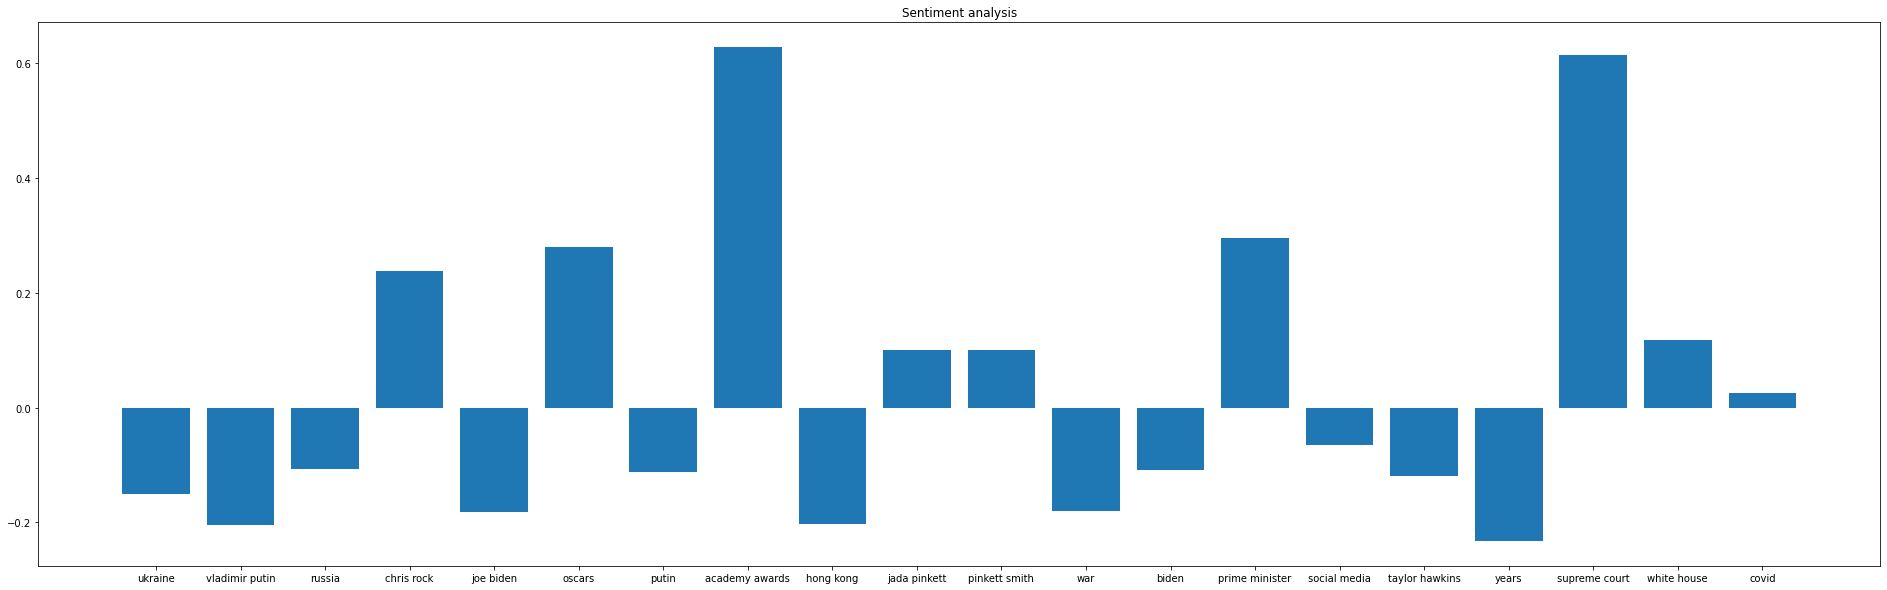

In [20]:
import matplotlib.pyplot as plt
fig = plt.figure(1, [33,10])
plt.title('Sentiment analysis')
if (max(top_avg_setniments.values())<0.5 and min(top_avg_setniments.values())>-0.5): # To have a more beautiful and of course, more understandable chart:)
  plt.ylim(-0.5, 0.5)
plt.bar(*zip(*top_avg_setniments.items()))
fig.patch.set_facecolor('white')
plt.show()